# Data Augmentation with Stacked Autoencoder

## Download data

In [1]:
# !gsutil -m cp gs://dataham/Dataset/MEL/train_mel.npy ./data

In [2]:
# !gsutil -m cp gs://dataham/Dataset/MEL/test_mel.npy ./data

In [3]:
# !gsutil -m cp gs://dataham/Dataset/NV/train_nv.npy ./data

In [4]:
# !gsutil -m cp gs://dataham/Dataset/NV/test_nv.npy ./data

## Import data

In [15]:
import numpy as np

In [16]:
train_mel = np.load('./data/train_mel.npy')
test_mel = np.load('./data/test_mel.npy')
train_nv = np.load('./data/train_nv.npy')
test_nv = np.load('./data/test_nv.npy')

## Construct and train stacked autoencoder

In [17]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model
from keras import backend as K

import matplotlib
import matplotlib.pyplot as plt

In [19]:
BOTTLENECK = 8
LAYER_NO = 8
BATCH_SIZE = 8
EPOCH_NO = 40

In [12]:
def build_autoencoder():
    input_img = Input(shape=(128, 128, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(BOTTLENECK, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    decoder_input = Input(shape=(8, 8, BOTTLENECK))

    x = Conv2D(BOTTLENECK, (3, 3), activation='relu', padding='same')(decoder_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    encoder = Model(input_img, encoded)
    decoder = Model(decoder_input, decoded)

    autoencoder = Model(input_img, decoder(encoded))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder, encoder, decoder

autoencoder_mel, encoder_mel, decoder_mel = build_autoencoder()
autoencoder_nv, encoder_nv, decoder_nv = build_autoencoder()

In [11]:
# autoencoder.summary()

In [ ]:
history_mel = autoencoder_mel.fit(train_mel, train_mel,
                                  epochs=EPOCH_NO, batch_size=BATCH_SIZE,
                                  validation_data=(test_mel, test_mel))

In [ ]:
history_nv = autoencoder_nv.fit(train_nv, train_nv,
                                epochs=EPOCH_NO, batch_size=BATCH_SIZE,
                                validation_data=(test_nv, test_nv))

## Save/Load the models

In [16]:
def save_sub_model(name, sub_model):
    file_path = "./models/{}-{}-{}-{}-{}.h5".format(name, BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO)
    sub_model.save(file_path)

def save_model(name, autoencoder, encoder, decoder):
    save_sub_model("autoencoder-{}".format(name), autoencoder)
    save_sub_model("encoder-{}".format(name), encoder)
    save_sub_model("decoder-{}".format(name), decoder)

save_model("mel", autoencoder_mel, encoder_mel, decoder_mel)
save_model("nv", autoencoder_nv, encoder_nv, decoder_nv)

In [23]:
LOAD = True

if LOAD:
    autoencoder_mel = load_model("./models/autoencoder-mel-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))
    encoder_mel = load_model("./models/encoder-mel-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))
    decoder_mel = load_model("./models/decoder-mel-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))
    
    autoencoder_nv = load_model("./models/autoencoder-nv-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))
    encoder_nv = load_model("./models/encoder-nv-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))
    decoder_nv = load_model("./models/decoder-nv-{}-{}-{}-{}.h5".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO))

Instructions for updating:
Use tf.cast instead.


/home/eminbahadir98/.local/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Check the model performance

In [19]:
def plot_performance(history, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    file_path = "./plots/stacked_vae/sv-{}-{}-{}-{}-{}.png".format(name, BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO)
    plt.savefig(file_path)
    plt.show()

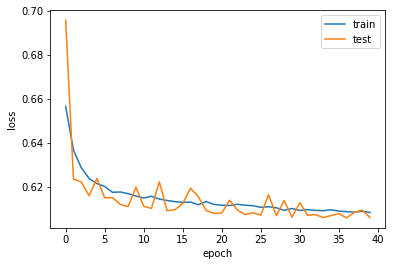

In [20]:
plot_performance(history_mel, "mel")

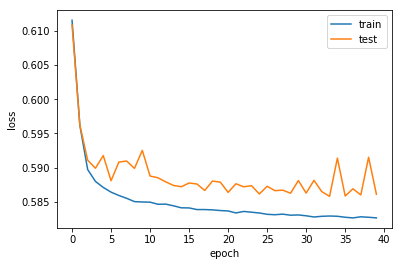

In [21]:
plot_performance(history_nv, "nv")

In [24]:
n = 10

def show_imgs(generated_imgs):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = generated_imgs[i].reshape(128, 128, 3)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def show_samples(train_data, encoder, decoder):
    values = encoder.predict(train_mel)
    means = np.mean(values, (0, ))
    stds = np.std(values, (0, ))
    dims = values.shape[1:]

    random_inputs = np.zeros((n, ) + dims)
    for i in range(n):
        random_inputs[i] = np.random.normal(means, stds)

    generated_imgs = decoder.predict(random_inputs)
    show_imgs(generated_imgs)

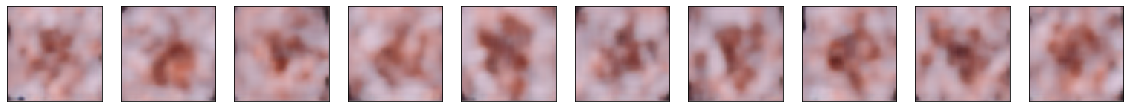

In [27]:
show_samples(train_mel, encoder_mel, decoder_mel)

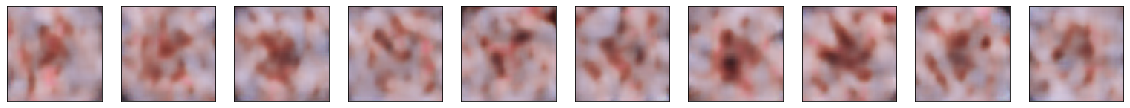

In [28]:
show_samples(train_nv, encoder_nv, decoder_nv)

In [47]:
def show_encodings(train_data, autoencoder):
    decoded_imgs = autoencoder.predict(train_data[:10])
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(train_data[i].reshape(128, 128, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

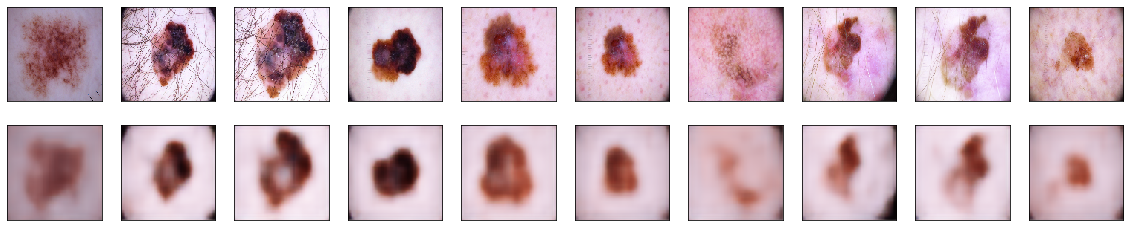

In [48]:
show_encodings(train_mel, autoencoder_mel)

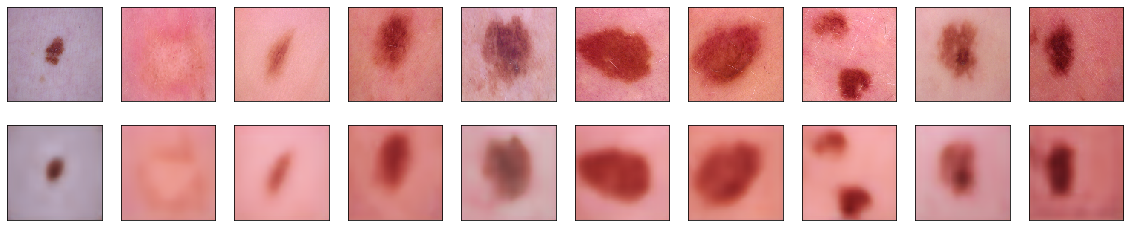

In [49]:
show_encodings(train_nv, autoencoder_nv)

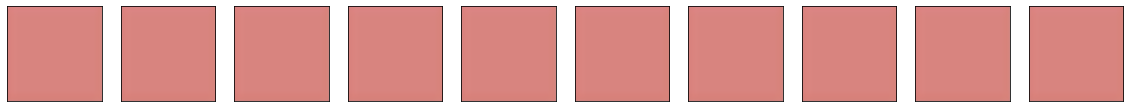

In [69]:
n = 10

def show_samples_2(decoder):
    dims = (8, 8, 8)
    means = np.zeros((n, ) + dims)
    stds = np.ones((n, ) + dims) * 0
    
    random_inputs = np.random.normal(means, stds)

    generated_imgs = decoder.predict(random_inputs)
    show_imgs(generated_imgs)
    
show_samples_2(decoder_nv)

## Perform augmentation

In [51]:
def augment(encoder, decoder, train_data, amount):
    values = encoder.predict(train_data)
    means = np.mean(values, (0, ))
    stds = np.std(values, (0, ))
    dims = values.shape[1:]
    random_inputs = np.zeros((amount, ) + dims)
    for i in range(amount):
        random_inputs[i] = np.random.normal(means, stds)
    generated_data = decoder.predict(random_inputs)
    return generated_data

Generate 3500 MEL images

In [52]:
augmented_mel = augment(encoder_mel, decoder_mel, train_mel, 3500)

In [53]:
np.save("./generated/stacked_vae_mel_{}-{}-{}-{}.npy".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO), augmented_mel)

Generate 4600 NV images

In [54]:
augmented_nv = augment(encoder_nv, decoder_nv, train_nv, 4600)

In [55]:
np.save("./generated/stacked_vae_nv_{}-{}-{}-{}.npy".format(BOTTLENECK, LAYER_NO, BATCH_SIZE, EPOCH_NO), augmented_nv)